In [3]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using Ipopt
using StaticArrays
using TrajectoryOptimization
using Altro
using RobotDynamics
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`


In [2]:
# TODO: Leaning back and forth: do that to test
# Add a torque going around the pitch and roll input
# 3 inputs + the contact forces
# 12 dimensional 

## 3D Hopper

The 3D hopper is composed of a prismatic joint and (two?) revolute joint(s), and makes the assumption that torque effects are equal and opposite at the head and foot. An image is shown below (copy that image in when you have time). It is parameterized by the following:  

$$ x = \begin{bmatrix} 
        x_{head} \\
        y_{head} \\
        z_{head} \\
        x_{foot} \\
        y_{foot} \\
        z_{foot} \\
        \dot x_{head} \\
        \dot y_{head} \\
        \dot z_{head} \\
        \dot x_{foot} \\
        \dot y_{foot} \\
        \dot z_{foot} \\
       \end{bmatrix} $$
        
$$ u = \begin{bmatrix}
        F_{pris} \\
        F_{pitch} \\
        F_{roll} \\
        F_{x, contact} \\
        F_{y, contact} \\
        F_{z, contact} \\
       \end{bmatrix} $$

In [2]:
# 2D Hopper, parameterized by the following:

function dynamics_3d(x, u)
    # x is a 12-dimensional vector, u is a 6-dimensional vector
    mh = 1.0
    mf = 1.0
    l = 1.0
    g = 9.81
    states = 12
    controls = 6
    v = x[Int(states/2):states]
    
    
    # TODO: determine what Jx, Jy, Jz are 
    headVec = x[1:3]
    footVec = x[4:6]
    
    bodyDirec = (headVec .- footVec) ./ norm(headVec .- footVec)
    xHat = bodyDirec[1]
    yHat = bodyDirec[2]
    zHat = bodyDirec[3]
    
    # cosTh = (headVec[1] - footVec[1]) / norm(headVec - footVec)
    # sinTh = (headVec[3] - footVec[3]) / norm(headVec - footVec)
    
    J = u[1]
    pitch = u[2]
    roll = u[3]
    λx = u[4]
    λy = u[5]
    λz = u[6]
    
    Jx, Jy, Jz = J .* bodyDirec
    
    axh = Jx + pitch*zHat
    ayh = Jy - roll*zHat
    azh = Jz - pitch*xHat + roll*yHat - mh*g
    axf = λx - Jx - pitch*zHat
    ayf = λy - Jy + roll*zHat
    azf = λz - Jz + pitch*xHat - roll*yHat - mf*g
    
    return [v; axh; ayh; azh; axf; ayf; azf]
end


function dynamics_3d_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_3d(x, u)
    f2 = dynamics_3d(x + 0.5*h*f1, u)
    f3 = dynamics_3d(x + 0.5*h*f2, u)
    f4 = dynamics_3d(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end


struct Hopper <: AbstractModel end
RobotDynamics.state_dim(::Hopper) = 12
RobotDynamics.control_dim(::Hopper) = 6


function RobotDynamics.dynamics(::Hopper,x,u)
    ẋ = dynamics_3d(x, u)
end


LoadError: UndefVarError: AbstractModel not defined

In [4]:
# Initialize the visualizer
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [5]:
function kinematics(x)
    return [x[1], x[2]]
end

function visualize!(vis, Xs, h)
    r_body = 0.2
    r_foot = 0.1
    r_leg = 0.5*r_foot
    
    setvisible!(vis["/Background"], true)
    headSphere = Sphere(Point3f0(0), convert(Float32, r_body))
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    legSphere = Sphere(Point3f0(0), convert(Float32, r_leg))
    setobject!(vis["body"], headSphere, MeshPhongMaterial(color = RGBA(1.0, 0.0, 1.0, 1.0)))
    setobject!(vis["foot"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], legSphere, MeshPhongMaterial(color=RGBA(0.0, 0.0, 0.0, 1.0)))
    end
    
    p_leg = [zeros(3) for i = 1:n_leg]
    
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = [x[1], 0.0, x[2]]
        p_foot = [x[3], 0.0, x[4]]
        
        z_shift = [0.0, 0.0, r_foot]
        zDist = x[2] - x[4]
        xDist = x[1] - x[3]
        
        for i = 1:n_leg
            p_leg[i] .= [xDist/n_leg*i + x[3], 0.0, zDist/n_leg*i + x[4]]
        end
        
        
        
        MeshCat.atframe(anim, t) do 
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))
            
            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
    end
    MeshCat.setanimation!(vis, anim)
end
            

visualize! (generic function with 1 method)

In [6]:
function stance_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A1 = zeros(3, n)
    # Pin the foot to the floor
    A1[1, 7] = 1.0
    A1[2, 4] = 1.0
    A1[3, 8] = 1.0
    b1 = SVector{3}([0.0, 0.0, 0.0])
    return LinearConstraint(n, m, A1, b1, Equality(), 1:n)
end


function flight_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A2 = zeros(2, m)
    # Constrain the contact forces to be 0
    A2[1, 3] = 1.0
    A2[2, 4] = 1.0
    b2 = SVector{2}(0.0, 0.0)
    return LinearConstraint(n, m, A2, b2, Equality(), (n+1):(n+m))
end


function friction_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(1, m)
    μ = 0.5
    A[1, 3] = 1.0
    A[1, 4] = -μ
    b = SVector{1}(0.0)
    forward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    
    A = zeros(1, m)
    μ = 0.5
    A[1, 3] = -1.0
    A[1, 4] = -μ
    b = SVector{1}(0.0)
    backward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    return forward, backward
end


function normal_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(1, m)
    A[1, 4] = -1.0
    b = SVector{1}(0.0)
    return LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
end


function bin_mode_list(N, mSteps; iState=1)
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    return modeList
end

function add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, forward, i)
        add_constraint!(conSet, backward, i)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

add_all_constraints! (generic function with 1 method)


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 14
    Solve Time: 10143.5738 (ms)

  Covergence
    Terminal Cost: 69.38107784869945
    Terminal dJ: -3.8097043955076515e-6
    Terminal gradient: 1.2324086552660578
    Terminal constraint violation: 3.741022858155394e-6
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{4},Float64,1,4}[[9.838782301081157, 3.79387988874867, 3.865743620053551, 19.619777941903223], [9.799197132653704, -0.5204582837556049, -0.0807776463255268, 19.62186252762567], [9.757446603712838, -1.0418075298047615, -0.16560118210647243, 19.620790833126144], [9.69966496046818, -1.4885962314308938, -0.19912836799107256, 19.620601492889858], [9.624987609867174, -1.9164863943637591, -0.24374616497922158, 19.620429402511583], [9.53629403596472, -2.3234595171006545, -0.30312229746762176, 19.62024446336271], [9.437085087203434, -2.706865

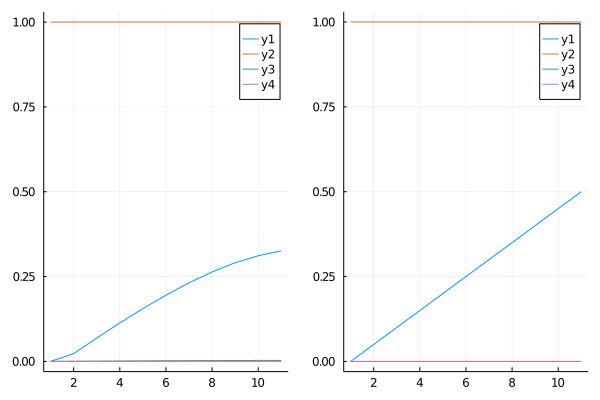

In [7]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 11
    h = 0.1
    mSteps = N
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.5, 0.0, 2*g]
    currX = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 1000.0 * costInit
    Qf = 100.0 * I(n)
    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    for i = 2:N
        xRefSimp[2, i] = 1.0#  xRefSimp[2, i-1] - 0.1
        xRefSimp[1, i] = xRefSimp[1, i-1] + 0.05
        xRefSimp[5, i] = 0.1
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    flgt = flight_constraints_2d(model)
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    exampleTurn = zeros(n, N)
    exampleTurn[:, 1] .= currX
    exCon = [g, 1.0, 2*g]
    for i = 2:N
        exampleTurn[:, i] = dynamics_2d_rk4(exampleTurn[:, i-1], exCon, h)
    end
    
    exTurn = [SVector{n}(exampleTurn[:, i]) for i = 1:N]
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    println(solveU)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
end

## Forward hopping motions


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 20
    Solve Time: 1682.254101 (ms)

  Covergence
    Terminal Cost: 15538.223688893384
    Terminal dJ: 0.06781472334841965
    Terminal gradient: 161.31283572846067
    Terminal constraint violation: 9.476511788991453e-7
    Solve Status: SOLVE_SUCCEEDED


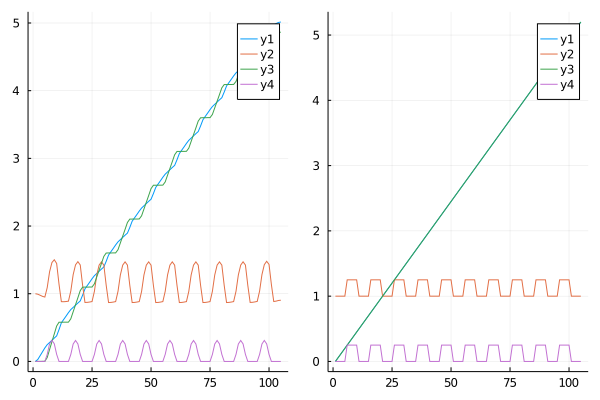

In [8]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 105
    h = 0.1
    mSteps = 5
    
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 2*g]
    currX = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    costInit = Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 500.0 * costInit
    
    Qf = 250.0 * I(n)

    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[2, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        if modeList[i] != 1    
            xRefSimp[2, i] = 1.25
            xRefSimp[4, i] = 0.25
        end
        xRefSimp[1, i] = xRefSimp[1, i-1] + 0.05
        xRefSimp[3, i] = xRefSimp[3, i-1] + 0.05
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    # println(solveU)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end


## Back and forth hopping


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 80
    Solve Time: 1805.62 (ms)

  Covergence
    Terminal Cost: 134236.89342689852
    Terminal dJ: -0.0138393692614045
    Terminal gradient: 2146.008874915434
    Terminal constraint violation: 8.2609681416041e-6
    Solve Status: SOLVE_SUCCEEDED


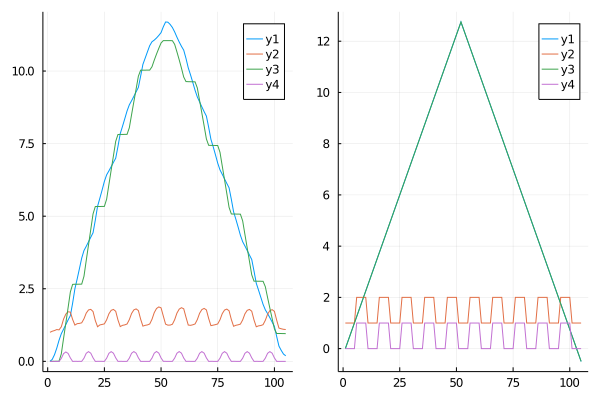

In [15]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 105
    h = 0.1
    mSteps = 5
      
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 2*g]
    currX = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 1000.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 1400.0 * I(n)

    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[2, :] .= 1.0
    uRefSimp = zeros(m, N-1)
    
    backState = 1
    xShift = 0.25
    for i = 2:N
        if i > N/2
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
        else
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
        end
            
        if modeList[i] != 1    
            xRefSimp[2, i] = 2.0
            xRefSimp[4, i] = 1.0
        end
        
        
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end

## Backflip


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 101
    Solve Time: 159.45999999999998 (ms)

  Covergence
    Terminal Cost: 2016.0490441726593
    Terminal dJ: 0.0003538533969731361
    Terminal gradient: 33.11200297119268
    Terminal constraint violation: 1.2241152363460939e-5
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{4},Float64,1,4}[[52.352411408568635, -11.351718472718947, 0.14581076872952642, 127.01457262969295], [-0.5654569849861322, 2.238908150430541, 9.042639175103301e-5, 0.0003208530986708819], [-7.780653233522729, 1.0792738198712788, -2.4785459064269712e-5, 0.00016265503266227392], [-18.788624656389178, -5.794858377483184, -1.5645294786723247e-5, 0.00023933770257606683], [-6.376510893566578, -0.5235501015817512, -4.431712690805577e-5, 0.00016315975291457966], [-5.207416719798183, 0.22832990562384897, -6.951886826694296e-5, 0.0001

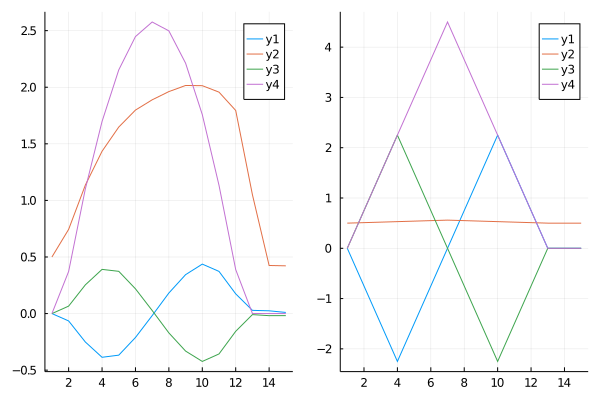

In [63]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 15
    st = 13
    h = 0.1
    mSteps = N
      
    modeList = ones(1, N) * 2.0
    modeList[1] = 1.0
    # modeList[end] = 1.0
    modeList[st:N] .= 1.0
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 2*g]
    currX = [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 50.0 * Diagonal([5.0, 5.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 500.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])

    R = 0.1* I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    uRefSimp = zeros(m, N-1)
    
    xShift = 0.75
    yShift = 0.01
    for i = 2:N
        if i-1 <= st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/4 && i-1 <= st/2
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/2 && i-1 <= 3*st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = -xShift
        elseif i-1 > 3*st/4 && i-1 <= st
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = -xShift
        end
    end
    
    xRefSimp[:, st:end] .= currX

    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    println(solveU)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end